# TRT KPI: Minimize Time to Science

The following KPIs are measured in this notebook:

* Number of lines of code for a given workflow in the cloud / Number of lines for same workflow on-prem
* Run time for a given workflow in the cloud / run time for same workflow on-prem

#### Workflows: 
* Basic data search, customize, access, plotting, with a collection that is available on-prem and in Earthdata Cloud.
* Data tested:
    * Single ICESat-2 data product: ATL03 v003
        * C1234714691-EEDTEST -> Harmony-enabled, UAT
        * C1233596099-NSIDC_TS1 -> EGI-enabled, UAT
* For future consideration:
    * Coincident data search/access/plot with another product
    * Different data access options beyond Harmony (direct s3, cloudfront, OPeNDAP)

## Import packages

In [1]:
import sys
import requests
from getpass import getpass
from platform import system
from netrc import netrc
from os.path import join, expanduser
from urllib import request
from http.cookiejar import CookieJar
import json
from pprint import pprint
import os
import time
import zipfile
import io
import shutil
import h5py
from pathlib import Path
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import time
from harmony import BBox, Client, Collection, Request, LinkType
from harmony.config import Environment
import datetime as dt
import s3fs
import xarray as xr

# from IPython.display import display, JSON
# import rasterio
# import rasterio.plot
# !{sys.executable} -m pip install intake #install intake into Python kernel
# import intake


## __On Prem workflow__

In [ ]:
# gather times to add up end to end
onprem_times = []

### 1. Authenticate against Earthdata Login

#### Steps Involved:

1. (Non-Code) Register an Earthdata Login Account
1. (Non-Code) Verify Earthdata Login account
1. (Non-Code) Add Earthdata Login credentials to .netrc file
1. Set up code to authenticate if redirected to Earthdata Login **(Note: this is automatic if using the Python requests library.  This cell may not be actually used.)**

In [ ]:
t0 = time.time()
def setup_earthdata_login_auth(endpoint: str='urs.uat.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
# Start authenticated session with URS to allow restricted data downloads:
setup_earthdata_login_auth(endpoint="urs.uat.earthdata.nasa.gov")
wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

### 2. Set up CMR token auth

#### Steps Involved:

5. Obtain Earthdata Login username and password in code
1. Obtain own IP address (or decide to lie to CMR)
1. Format username, password, and IP address to CMR XML format
1. Perform token request against CMR
1. Parse token request output to obtain the token as a string

In [ ]:
t0 = time.time()
TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>NSIDC TS1 Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.uat.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']





# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.uat.earthdata.nasa.gov")
wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

### 3. Declare time and bounding box search parameters

_Using a bounding box that will cover granules in EEDTEST (limiting factor compared to data in TS1)_

#### Steps Involved:

10. Format desired spatial bounding box into CMR query format
1. Format desired temporal range into CMR query format
1. (Non-Code) Determine precise data product short name (perhaps already known by users)
1. Set data product short name in code
1. (Non-Code) Determine precise data product version identifier, including leading zeroes
1. Set data product version identifier in code
1. (Non-Code) Determine data provider identifier for the collection owner
1. Set data provider identifier in code

##### Alternative for 12-17

12. (Non-Code) Go to Earthdata Search
1. (Non-Code) Search for data product short name or similar
1. (Non-Code) Select correct collection, revealing CMR Concept ID
1. Copy/paste the CMR Concept ID into code


In [ ]:
t0 = time.time()
# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-13.1,-72.7,114.5,-65.5'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2020-01-01T00:00:00Z,2020-02-10T23:59:59Z'

search_parameters= {'short_name': 'ATL03',
               'version': '003', 
               'provider': 'NSIDC_TS1',
               'bounding_box': bounding_box,
               'temporal': temporal,
                   }
wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

### 4. Search for granules based on time and bounding box

#### Steps Involved:

**Assumption:** The user's desired results are contained on the first page of results, but larger than the default (10)

18. Set the token as a request parameter
1. Set desired CMR output format (using the default requires more steps to get at the desired information)
1. Set the CMR page size to be large enough to contain all results
1. Perform CMR granule search using provided parameters
1. Parse the search result
1. Retrieve granule records from the search result (Note: I break this out because it's relatively hard to get at)

##### Skipped steps (not strictly necessary)
* Error checking
* Hits reporting
* Set CMR parameter to scroll results (code does not go past the first page)

In [ ]:
t0 = time.time()
def search_granules(search_parameters, token, geojson=None, output_format="json"):
    """
    Performs a granule search with token authentication for restricted results
    
    :search_parameters: dictionary of CMR search parameters
    :token: CMR token needed for restricted search
    :geojson: filepath to GeoJSON file for spatial search
    :output_format: select format for results https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#supported-result-formats
    
    :returns: if hits is greater than 0, search results are returned in chosen output_format, otherwise returns None.
    """
    search_url = "https://cmr.uat.earthdata.nasa.gov/search/granules"
    
    # add token to search parameters
    search_parameters['token'] = token
    
    if geojson:
        files = {"shapefile": (geojson, open(geojson, "r"), "application/geo+json")}
    else:
        files = None
    
    
    parameters = {
        "scroll": "true",
        "page_size": 100,
    }
    
    try:
        response = requests.post(f"{search_url}.{output_format}", params=parameters, data=search_parameters, files=files)
        response.raise_for_status()
    except HTTPError as http_err:
        print(f"HTTP Error: {http_error}")
    except Exception as err:
        print(f"Error: {err}")
    
    hits = int(response.headers['CMR-Hits'])
    if hits > 0:
        print(f"Found {hits} files")
        results = json.loads(response.content)
        granules = []
        granules.extend(results['feed']['entry'])
        granule_sizes = [float(granule['granule_size']) for granule in granules]
        print(f"The total size of all files is {sum(granule_sizes):.2f} MB")
        return response.json()
    else:
        print("Found no hits")
        return

search_granules(search_parameters, _token)
wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

### 5. Determine subsetting service options

#### Steps Involved:

24. Set the token as a request parameter
1. Set desired CMR output format for collections (using the default requires more steps to get at the desired information)
1. Perform CMR collection search using the collection-related search fields
1. Parse the search result
1. Retrieve collection from the search result
1. Retrieve associated service IDs from the collection
1. Set desired (different) output format for services
1. Format a query to fetch the service for each service ID (why isn't this a link relation?)
1. Perform CMR service search for each each service ID
1. Parse the search result
1. Retrieve service from the search result
1. Retrieve associated service options from the service


In [ ]:
t0 = time.time()
def search_services(search_parameters, token, output_format="json"):
    """
    Performs a granule search with token authentication for restricted results
    
    :search_parameters: dictionary of CMR search parameters
    :token: CMR token needed for restricted search
    :output_format: select format for results https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#supported-result-formats
    
    :returns: if hits is greater than 0, search results are returned in chosen output_format, otherwise returns None.
    """
    collection_url = "https://cmr.uat.earthdata.nasa.gov/search/collections"
    
    # add token to search parameters
    search_parameters['token'] = token
    
    parameters = {
        "scroll": "true",
        "page_size": 100,
    }
    
    try:
        response = requests.post(f"{collection_url}.{output_format}", params=parameters, data=search_parameters)
        response.raise_for_status()
    except HTTPError as http_err:
        print(f"HTTP Error: {http_error}")
    except Exception as err:
        print(f"Error: {err}")
    
    hits = int(response.headers['CMR-Hits'])
    if hits > 0:
        response = response.json()
        if 'services' in response['feed']['entry'][0]['associations']: 
            services = response['feed']['entry'][0]['associations']['services']
            output_format = "umm_json"
            service_url = "https://cmr.uat.earthdata.nasa.gov/search/services"
            for i in range(len(services)):
                response = requests.get(f"{service_url}.{output_format}?concept-id={services[i]}")
                response = response.json()
                if 'ServiceOptions' in response['items'][0]['umm']: pprint(response['items'][0]['umm']['ServiceOptions'])
        else:
            print("Found no services")
        return
    else:
        print("Found no hits")
        return

search_services(search_parameters, _token)
wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

### 6. Determine variables

_Today there are no UMM-Var records for the on-prem collection_

#### Steps Involved:

N/A

#### 7. Determine variables: Authenticate against EGI endpoint

#### Steps Involved:

36. (External) Determine EGI URL and format
1. Format EGI capabilities URL with collection short name and version
1. Perform EGI capabilities GET request

In [ ]:
t0 = time.time()
uid = input('Earthdata Login user name: ') # Enter Earthdata Login user name
pswd = getpass('Earthdata Login password: ') # Enter Earthdata Login password

# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil12u.ecs.nsidc.org/egi_TS1/capabilities/{search_parameters["short_name"]}.{search_parameters["version"]}.xml'

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

#### 8. Determine variables: Query EGI for variables

#### Steps Involved:

39. Parse the EGI response
1. Locate each variable in the response
1. Extract the variable name from each variable
1. Ensure that each variable starts with a leading '/', inserting it if not **(Note: output looks buggy)**
1. Replace ':' with '/' in variable names to form more conventional variable paths
1. Locate each format option in the response
1. Extract the format name from each format
1. Remove empty formats that were returned
1. Locate each projection option in the response

In [ ]:
t0 = time.time()

root = ET.fromstring(response.content)

#collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]
if len(subagent) > 0 :

    # variable subsetting
    variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
    variables_raw = [variables[i]['value'] for i in range(len(variables))]
    variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
    variable_vals = [v.replace(':', '/') for v in variables_join]

    # reformatting
    formats = [Format.attrib for Format in root.iter('Format')]
    format_vals = [formats[i]['value'] for i in range(len(formats))]
    format_vals.remove('')

    # reprojection options
    projections = [Projection.attrib for Projection in root.iter('Projection')]
    
print(variable_vals)

wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

### 9. Request variable subset

_Starting with a variable subsetting request, since spatial subsetting for ICESat-2 is not available yet in the cloud. Alternatively we could attempt to spatially subset without services (i.e. subsetting using xarray)_

#### Steps Involved:

48. Select all desired variables and provide them in code
1. (External) Determine URL format for an EGI subset request
1. Format desired variables for a URL query string
1. Construct URL using URL, temporal, variable, and spatial parameters from prior requests
1. Specify additional bbox subset parameter to equal bounding box spatial filter from prior request  

##### Notes
* Assumes prior requests define formatted temporal and bounding box

#### Request variable subset: Determine API request 

_This isn't really required so not including it as a step_

In [ ]:
#Set NSIDC data access base URL
base_url = 'https://n5eil12u.ecs.nsidc.org/egi_TS1/request'

# bounding box search and subset:
param_dict = {'short_name': 'ATL03', 
              'version': '003', 
              'temporal': temporal, 
              'bounding_box': bounding_box, 
              'bbox': bounding_box, 
              'coverage': '/gt1r/heights/h_ph,/gt1l/heights/h_ph,/gt2r/heights/h_ph,/gt2l/heights/h_ph,/gt1r/heights/lat_ph,/gt1l/heights/lat_ph,/gt2r/heights/lat_ph,/gt2l/heights/lat_ph,/gt1r/heights/lon_ph,/gt1l/heights/lon_ph,/gt2r/heights/lon_ph,/gt2l/heights/lon_ph',
              'page_size': '10', 
              'request_mode': 'async',
              'email': '',
              'token' : _token,
             }

#Remove blank key-value-pairs
param_dict = {k: v for k, v in param_dict.items() if v != ''}

#Convert to string
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
param_string = param_string.replace("'","")

API_request = api_request = f'{base_url}?{param_string}'
print(API_request)

#### 10. Request variable subset: Download customized data

#### Steps Involved:

53. Create / allocate a location for downloaded files
1. Perform subsetting HTTP request
1. Parse subsetting response
1. Extract order IDs from subsetting response
1. (External) Determine how to construct a URL to get an order from the EGI API
1. Construct an EGI order URL for the order ID
1. Create a loop to repeatedly poll order status
1. Perform the EGI request for the order
1. Parse the order response
1. Extract the order status from the response
1. Test if the order is still processing, looping if so (end of loop)
1. (External) Determine how to construct an EGI URL to fetch the results of an order
1. Construct an EGI URL to fetch order results from the order ID
1. Download the zip file of the order results
1. Unzip the order results zip file

##### Notes
* Ignoring failed orders, not necessary for happy path
* HTTP response code validation not included as not strictly necessary on the happy path

In [ ]:
t0 = time.time()

# Create an output folder if the folder does not already exist.

path = str(os.getcwd() + '/Outputs')
if not os.path.exists(path):
    os.mkdir(path)

# For all requests other than spatial file upload, use get function
request = session.get(base_url, params=param_dict)

print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
request.raise_for_status()
print('Order request URL: ', request.url)
esir_root = ET.fromstring(request.content)
print('Order request response XML content: ', request.content)

#Look up order ID
orderlist = []   
for order in esir_root.findall("./order/"):
    orderlist.append(order.text)
orderID = orderlist[0]
print('order ID: ', orderID)

#Create status URL
statusURL = base_url + '/' + orderID
print('status URL: ', statusURL)

#Find order status
request_response = session.get(statusURL)    
print('HTTP response from order response URL: ', request_response.status_code)

# Raise bad request: Loop will stop for bad response code.
request_response.raise_for_status()
request_root = ET.fromstring(request_response.content)
statuslist = []
for status in request_root.findall("./requestStatus/"):
    statuslist.append(status.text)
status = statuslist[0]
print('Data request is submitting...')
print('Initial request status is ', status)

#Continue loop while request is still processing
while status == 'pending' or status == 'processing': 
    print('Status is not complete. Trying again.')
    time.sleep(10)
    loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
    loop_response.raise_for_status()
    loop_root = ET.fromstring(loop_response.content)

#find status
    statuslist = []
    for status in loop_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Retry request status is: ', status)
    if status == 'pending' or status == 'processing':
        continue

#Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
if status == 'complete_with_errors' or status == 'failed':
    messagelist = []
    for message in loop_root.findall("./processInfo/"):
        messagelist.append(message.text)
    print('error messages:')
    pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
if status == 'complete' or status == 'complete_with_errors':
    downloadURL = 'https://n5eil12u.ecs.nsidc.org/esir_TS1/' + orderID + '.zip'
    print('Zip download URL: ', downloadURL)
    print('Beginning download of zipped output...')
    zip_response = session.get(downloadURL)
    # Raise bad request: Loop will stop for bad response code.
    zip_response.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
        z.extractall(path)
    print('Data request is complete.')
else: print('Request failed.')
    
wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

#### 11. Clean up Outputs folder by removing individual granule folders 

In [ ]:
t0 = time.time()

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
    for name in dirs:
        os.rmdir(os.path.join(root, name))

wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

### 12. Read in Data using h5py

#### Steps Involved:

68. Loop over each resulting data file (Not done in this code, but would be needed in a general case)
1. Open the result using h5py
1. Loop over each variable of interest
1. Correct for flag values not handled by h5py in each variable

In [ ]:
t0 = time.time()

def load_icesat2_as_dataframe(filepath, VARIABLES):
    '''
    Load points from an ICESat-2 granule 'gt<beam>' groups as DataFrame of points. Uses VARIABLES mapping
    to select subset of '/gt<beam>/...' variables  (Assumes these variables share dimensions)
    Arguments:
        filepath to ATL0# granule
    '''
    
    ds = h5py.File(filepath, 'r')

    # Get dataproduct name
    dataproduct = ds.attrs['identifier_product_type'].decode()
    # Convert variable paths to 'Path' objects for easy manipulation
    variables = [Path(v) for v in VARIABLES[dataproduct]]
    # Get set of beams to extract individially as dataframes combining in the end
    beams = {list(v.parents)[-2].name for v in variables}
    
    dfs = []
    for beam in beams:
        data_dict = {}
        beam_variables = [v for v in variables if beam in str(v)]
        for variable in beam_variables:
            # Use variable 'name' as column name. Beam will be specified in 'beam' column
            column = variable.name
            variable = str(variable)
            try:
                values = ds[variable][:]
                # Convert invalid data to np.nan (only for float columns)
                if 'float' in str(values.dtype):
                    if 'valid_min' in ds[variable].attrs:
                        values[values < ds[variable].attrs['valid_min']] = np.nan
                    if 'valid_max' in ds[variable].attrs:
                        values[values > ds[variable].attrs['valid_max']] = np.nan
                    if '_FillValue' in ds[variable].attrs:
                        values[values == ds[variable].attrs['_FillValue']] = np.nan
                    
                data_dict[column] = values
            except KeyError:
                print(f'Variable {variable} not found in {filepath}. Likely an empty granule.')
                raise
                
        df = pd.DataFrame.from_dict(data_dict)
        df['beam'] = beam
        dfs.append(df)
        
    df = pd.concat(dfs, sort=True)
    # Add filename column for book-keeping and reset index
    df['filename'] = Path(filepath).name
    df = df.reset_index(drop=True)
    
    return df

wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

In [ ]:
t0 = time.time()

atl_filepath = './Outputs/processed_ATL03_20200131230704_05530610_003_01.h5' # Define local filepath 

VARIABLES = {
    'ATL03': [
        '/gt1l/heights/h_ph',
        '/gt1r/heights/h_ph',
        '/gt2l/heights/h_ph',
        '/gt2r/heights/h_ph',
        '/gt1l/heights/lat_ph',
        '/gt1r/heights/lat_ph',
        '/gt2l/heights/lat_ph',
        '/gt2r/heights/lat_ph',
        '/gt1l/heights/lon_ph',
        '/gt1r/heights/lon_ph',
        '/gt2l/heights/lon_ph',
        '/gt2r/heights/lon_ph',
        ]
}

atl03 = load_icesat2_as_dataframe(atl_filepath, VARIABLES)
print(atl03.tail())

wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

### 13. Plot data

**Due to the # of data values, the plotting is compute-intensive and may take several minutes**

#### Steps Involved:

72. Plot each variable (collapsed as incomplete, use-case-specific, and generally just necessary)

In [ ]:
t0 = time.time()

plt.figure(figsize=(10,8), dpi= 90)
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0))
ax.add_feature(cfeature.LAND)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, -65, -90], ccrs.PlateCarree())
plt.scatter(atl03.lon_ph,
            atl03.lat_ph,
            c=atl03.h_ph,
            cmap='viridis',
            vmin=100,vmax=200,
            transform=ccrs.PlateCarree())
plt.colorbar(label='elevation', shrink=0.5, extend='both')

wall_time = time.time() - t0
onprem_times.append(wall_time)
print (wall_time, "seconds wall time")

## Total on-prem time

In [ ]:
print("Total on prem time (sec):", sum(onprem_times))

## __Cloud workflow__


In [2]:
# gather times to add up end to end
cloud_times = []

### 1. Set up CMR token auth

#### Steps Involved:

1. (Non-Code) Register an Earthdata Login Account
1. (Non-Code) Verify Earthdata Login account
1. Obtain Earthdata Login username and password in code
1. Obtain own IP address (or decide to lie to CMR)
1. Format username, password, and IP address to CMR XML format
1. Perform token request against CMR
1. Parse token request output to obtain the token as a string

In [3]:
t0 = time.time()

TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>NSIDC TS1 Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_cmr_token_auth(endpoint: str='cmr.uat.earthdata.nasa.gov'):
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    return requests.post(
        url="https://%s/legacy-services/rest/tokens" % endpoint,
        data=TOKEN_DATA % (input("Username: "), getpass("Password: "), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    ).json()['token']['id']


# Get your authentication token for searching restricted records in the CMR:
_token = setup_cmr_token_auth(endpoint="cmr.uat.earthdata.nasa.gov")

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

Username:  amy.steiker
Password:  ·········


5.218868017196655 seconds wall time


### 2. Declare time and bounding box search parameters

_Using a bounding box that will cover granules in EEDTEST (limiting factor compared to data in TS1)_

#### Steps Involved:

8. Format desired spatial bounding box into CMR query format
1. Format desired temporal range into CMR query format
1. (Non-Code) Determine precise data product short name (perhaps already known by users)
1. Set data product short name in code
1. (Non-Code) Determine precise data product version identifier, including leading zeroes
1. Set data product version identifier in code
1. (Non-Code) Determine data provider identifier for the collection owner
1. Set data provider identifier in code

##### Alternative for 12-17

10. (Non-Code) Go to Earthdata Search
1. (Non-Code) Search for data product short name or similar
1. (Non-Code) Select correct collection, revealing CMR Concept ID
1. Copy/paste the CMR Concept ID into code


In [4]:
t0 = time.time()

# Bounding Box spatial parameter in decimal degree 'W,S,E,N' format.
bounding_box = '-13.1,-72.7,114.5,-65.5'

# Each date in yyyy-MM-ddTHH:mm:ssZ format; date range in start,end format
temporal = '2020-01-01T00:00:00Z,2020-02-10T23:59:59Z'

search_parameters= {'short_name': 'ATL03',
               'version': '003', 
               #'concept_id':'C1234714691-EEDTEST',
               'provider': 'EEDTEST',
               'bounding_box': bounding_box,
               'temporal': temporal,
                   }

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

9.107589721679688e-05 seconds wall time


### 3. Search for granules based on time and bounding box

#### Steps Involved:

**Assumption:** The user's desired results are contained on the first page of results, but larger than the default (10)

16. Set the token as a request parameter
1. Set desired CMR output format (using the default requires more steps to get at the desired information)
1. Set the CMR page size to be large enough to contain all results
1. Perform CMR granule search using provided parameters
1. Parse the search result
1. Retrieve granule records from the search result (Note: I break this out because it's relatively hard to get at)

##### Skipped steps (not strictly necessary)
* Error checking
* Hits reporting
* Set CMR parameter to scroll results (code does not go past the first page)

In [5]:
t0 = time.time()

def search_granules(search_parameters, token, geojson=None, output_format="json"):
    """
    Performs a granule search with token authentication for restricted results
    
    :search_parameters: dictionary of CMR search parameters
    :token: CMR token needed for restricted search
    :geojson: filepath to GeoJSON file for spatial search
    :output_format: select format for results https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#supported-result-formats
    
    :returns: if hits is greater than 0, search results are returned in chosen output_format, otherwise returns None.
    """
    search_url = "https://cmr.uat.earthdata.nasa.gov/search/granules"
    
    # add token to search parameters
    search_parameters['token'] = token
    
    if geojson:
        files = {"shapefile": (geojson, open(geojson, "r"), "application/geo+json")}
    else:
        files = None
    
    
    parameters = {
        "scroll": "true",
        "page_size": 100,
    }
    
    try:
        response = requests.post(f"{search_url}.{output_format}", params=parameters, data=search_parameters, files=files)
        response.raise_for_status()
    except HTTPError as http_err:
        print(f"HTTP Error: {http_error}")
    except Exception as err:
        print(f"Error: {err}")
    
    hits = int(response.headers['CMR-Hits'])
    if hits > 0:
        print(f"Found {hits} files")
        results = json.loads(response.content)
        granules = []
        granules.extend(results['feed']['entry'])
        granule_sizes = [float(granule['granule_size']) for granule in granules]
        print(f"The total size of all files is {sum(granule_sizes):.2f} MB")
        return response.json()
    else:
        print("Found no hits")
        return

search_granules(search_parameters, _token)

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

Found 2 files
The total size of all files is 1991.09 MB
0.37754273414611816 seconds wall time


### 4. Determine subsetting service options

#### Steps Involved:

22. Set the token as a request parameter
1. Set desired CMR output format for collections (using the default requires more steps to get at the desired information)
1. Perform CMR collection search using the collection-related search fields
1. Parse the search result
1. Retrieve collection from the search result
1. Retrieve associated service IDs from the collection
1. Set desired (different) output format for services
1. Format a query to fetch the service for each service ID (why isn't this a link relation?)
1. Perform CMR service search for each each service ID
1. Parse the search result
1. Retrieve service from the search result
1. Retrieve associated service options from the service


In [6]:
t0 = time.time()

def search_services(search_parameters, token, output_format="json"):
    """
    Performs a granule search with token authentication for restricted results
    
    :search_parameters: dictionary of CMR search parameters
    :token: CMR token needed for restricted search
    :output_format: select format for results https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#supported-result-formats
    
    :returns: if hits is greater than 0, search results are returned in chosen output_format, otherwise returns None.
    """
    collection_url = "https://cmr.uat.earthdata.nasa.gov/search/collections"
    
    # add token to search parameters
    search_parameters['token'] = token
    
    parameters = {
        "scroll": "true",
        "page_size": 100,
    }
    
    try:
        response = requests.post(f"{collection_url}.{output_format}", params=parameters, data=search_parameters)
        response.raise_for_status()
    except HTTPError as http_err:
        print(f"HTTP Error: {http_error}")
    except Exception as err:
        print(f"Error: {err}")
    
    hits = int(response.headers['CMR-Hits'])
    if hits > 0:
        response = response.json()
        if 'services' in response['feed']['entry'][0]['associations']: 
            services = response['feed']['entry'][0]['associations']['services']
            output_format = "umm_json"
            service_url = "https://cmr.uat.earthdata.nasa.gov/search/services"
            for i in range(len(services)):
                response = requests.get(f"{service_url}.{output_format}?concept-id={services[i]}")
                response = response.json()
                if 'ServiceOptions' in response['items'][0]['umm']: pprint(response['items'][0]['umm']['ServiceOptions'])
        else:
            print("Found no services")
        return
    else:
        print("Found no hits")
        return

search_services(search_parameters, _token)

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

{'Subset': {'SpatialSubset': {'BoundingBox': {'AllowMultipleValues': False}},
            'TemporalSubset': {'AllowMultipleValues': False},
            'VariableSubset': {'AllowMultipleValues': True}},
 'SupportedInputProjections': [{'ProjectionName': 'Geographic'}],
 'SupportedOutputProjections': [{'ProjectionName': 'Geographic'}]}
{'Subset': {'SpatialSubset': {'BoundingBox': {'AllowMultipleValues': False}},
            'TemporalSubset': {'AllowMultipleValues': False},
            'VariableSubset': {'AllowMultipleValues': True}},
 'SupportedInputProjections': [{'ProjectionName': 'Geographic'}],
 'SupportedOutputProjections': [{'ProjectionName': 'Geographic'}],
 'SupportedReformattings': [{'SupportedInputFormat': 'NETCDF-4',
                             'SupportedOutputFormats': ['ASCII',
                                                        'BINARY',
                                                        'GEOTIFF',
                                                        'NETCDF-3',

### 5. Determine variables

_Can use UMM-Var to return cleaner Long Names, and Name value needed for Harmony request_

#### Steps Involved:

34. Retrieve associated variable IDs from the collection
1. Set desired (different) output format for variables
1. Format a query to fetch the service for each variable ID (why isn't this a link relation?)
1. Perform CMR variable search for each variable ID
1. Parse the search result
1. Retrieve variable from the search result
1. Retrieve variable names from the variable

##### Notes
* Assumes we could reuse the already-searched and parsed collection record from service lookup step with refactoring


In [7]:
t0 = time.time()

def search_vars(search_parameters, token, output_format="json"):
    """
    Performs a granule search with token authentication for restricted results
    
    :search_parameters: dictionary of CMR search parameters
    :token: CMR token needed for restricted search
    :output_format: select format for results https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#supported-result-formats
    
    :returns: if hits is greater than 0, search results are returned in chosen output_format, otherwise returns None.
    """
    collection_url = "https://cmr.uat.earthdata.nasa.gov/search/collections"
    
    # add token to search parameters
    search_parameters['token'] = token
    
    parameters = {
        "scroll": "true",
        "page_size": 100,
    }
    
    try:
        response = requests.post(f"{collection_url}.{output_format}", params=parameters, data=search_parameters)
        response.raise_for_status()
    except HTTPError as http_err:
        print(f"HTTP Error: {http_error}")
    except Exception as err:
        print(f"Error: {err}")
    
    hits = int(response.headers['CMR-Hits'])
    if hits > 0:
        response = response.json()
        if 'variables' in response['feed']['entry'][0]['associations']: 
            variables = response['feed']['entry'][0]['associations']['variables']
            output_format = "umm_json"
            var_url = "https://cmr.uat.earthdata.nasa.gov/search/variables"
            for i in range(len(variables)):
                response = requests.get(f"{var_url}.{output_format}?concept-id={variables[i]}")
                response = response.json()
                if 'LongName' in response['items'][0]['umm']: 
                    pprint(response['items'][0]['umm']['LongName'])
                    pprint(response['items'][0]['umm']['Name'])
        else:
            print("Found no services")
        return
    else:
        print("Found no hits")
        return

search_vars(search_parameters, _token)

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

'background counts per bin'
'/gt1r/signal_find_output/ocean/bckgrd_mean'
'Segment latitude'
'/gt1r/geolocation/reference_photon_lat'
'Geoid'
'/gt1r/geophys_corr/geoid'
'Latitude'
'/gt1r/heights/lat_ph'
'Photon WGS84 Height'
'/gt1r/heights/h_ph'
'Longitude'
'/gt1r/heights/lon_ph'
'ATLAS 50-shot background count'
'/gt1r/bckgrd_atlas/bckgrd_counts'
'Segment longitude'
'/gt1r/geolocation/reference_photon_lon'
'Orbit Number'
'/orbit_info/orbit_number'
'Altitude'
'/gt1r/geolocation/altitude_sc'
'Photon Index Begin'
'/gt1r/geolocation/ph_index_beg'
10.216305017471313 seconds wall time


### 6. Request variable subset

_Starting with a variable subsetting request, since spatial subsetting for ICESat-2 is not available yet in the cloud. Alternatively we could attempt to spatially subset without services (i.e. subsetting using xarray)_

_Using Harmony-py, this is a few easy lines of code_

**Note that the exact same variables are not curated in umm-var compared to what was requested on-prem. For plotting purposes, 1 extra var is included on-prem for  **

#### Steps Involved:

41. Install harmony-py
1. Import harmony-py libraries
1. Create Harmony client with previously obtained auth (or set up / use .netrc)
1. Construct Harmony request object using desired spatial / temporal / variables
1. Submit the Harmony request, obtaining a Job ID

In [8]:
t0 = time.time()

granuleids = ['G1238435033-EEDTEST','G1238434996-EEDTEST']

harmony_client = Client(env=Environment.UAT)
request = Request(
    collection=Collection(id='ATL03'),
    granule_id=granuleids,
    variables=['/gt1r/signal_find_output/ocean/bckgrd_mean',
        '/gt1r/geolocation/reference_photon_lat',
        '/gt1r/geophys_corr/geoid',
        '/gt1r/heights/lat_ph',
        '/gt1r/heights/h_ph',
        '/gt1r/heights/lon_ph',
        '/gt1r/bckgrd_atlas/bckgrd_counts',
        '/gt1r/geolocation/reference_photon_lon',
        '/orbit_info/orbit_number',
        '/gt1r/geolocation/ph_index_beg'],
)
job_id = harmony_client.submit(request)
print(job_id)
#results = harmony_client.download_all(job_id, directory='/tmp', overwrite=True)

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

63b023fc-2213-4898-9a5b-e857e997ea88
5.180907964706421 seconds wall time


### 7. Retrieve AWS Credentials

#### Steps Involved:

46. Obtain AWS Credentials for in-region use

In [9]:
t0 = time.time()

creds = harmony_client.aws_credentials()
# print(creds)

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

0.6634731292724609 seconds wall time


### 8. Read in Data using xarray

#### Steps Involved:

47. Retrieve s3 URLs returned from Harmony
1. Create a file system using `s3fs` in order to read into `xarray`
1. Open the file system using h5py
1. Create xarray dataset from selected variables of interest in h5py object

In [10]:
t0 = time.time()

results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
s3_urls = list(results)
pprint(s3_urls)

s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

with s3_fs.open(s3_urls[1], 'rb') as s3f:
    with h5py.File(s3f, 'r') as f:
        gt1r = xr.Dataset({   
                       'latitude': (['x'], f['gt1r']['heights']['lat_ph'][:]), 
                       'longitude': (['x'], f['gt1r']['heights']['lon_ph'][:]),
                       'height': (['x'], f['gt1r']['heights']['h_ph'][:]),
                       })
print(gt1r)

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

['s3://harmony-uat-staging/public/sds/variable-subsetter/5dcf6af0-2cd1-4aca-a0cd-4a7677ab1540/EEDTEST-ATL03-003-ATL03_20200202T001542_subsetted.nc4',
 's3://harmony-uat-staging/public/sds/variable-subsetter/5dcf6af0-2cd1-4aca-a0cd-4a7677ab1540/EEDTEST-ATL03-003-ATL03_20200131T230704_subsetted.nc4']
<xarray.Dataset>
Dimensions:    (x: 11154405)
Dimensions without coordinates: x
Data variables:
    latitude   (x) float64 -50.0 -50.0 -50.0 -50.0 ... -79.01 -79.01 -79.01
    longitude  (x) float64 84.62 84.62 84.62 84.62 ... 74.88 74.88 74.88 74.88
    height     (x) float32 239.0 -238.2 -164.1 ... 3.654e+03 3.656e+03 3.656e+03
36.56947135925293 seconds wall time


### 9. Plot data in place

#### Steps Involved:

51. Plot each variable (collapsed as incomplete, use-case-specific, and generally just necessary)

4.299610614776611 seconds wall time


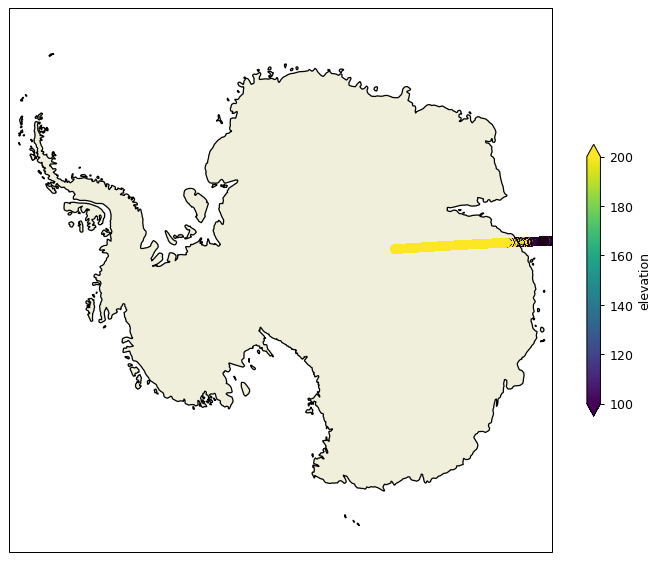

In [11]:
t0 = time.time()

# %matplotlib widget

plt.figure(figsize=(10,8), dpi= 90)
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0)) 
ax.add_feature(cfeature.LAND)
ax.set_extent([-180, 180, -65, -90], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.scatter(gt1r.longitude,
            gt1r.latitude,
            c=gt1r.height,
            cmap='viridis',
            vmin=100,vmax=200,
            transform=ccrs.PlateCarree())
plt.colorbar(label='elevation', shrink=0.5, extend='both')

# plt.show()

wall_time = time.time() - t0
cloud_times.append(wall_time)
print (wall_time, "seconds wall time")

## Total cloud time

In [12]:
print("Total cloud time (sec):", sum(cloud_times))

Total cloud time (sec): 66.61899757385254
